In [ ]:
# переводим все в нижний регистр, оставляем только цифры в одном формате, удаляем лишние пробелы
# удалить дубликаты 

# status - пустые значения 39918, выбираем top остальное - other?
# propertyType - пустые значения 34733, есть значения из колонки stories - переместить, пустоты заполнить типом по sqft.
# fireplace - 2/3 пустых значений (возможно заменить на no) - +
# baths - пустые значения 106338, значения вида "1 / 1-0 / 1-0 / 1-0" - просто сосчитать
# zipcode - индекс, есть "--"? - +
# street - пустые значения 2 - удалить, постараться привести к общему виду, попробовать получить координаты по адресу
# city - пустые значения 34 - удалить или получить по zipcode
# sqft - пустые значения 40577, есть нулевые значения и прочерки - присвоить -999 - +
# beds - пустые значения 91282, примешаны площадь в футах и акрах,  
# заполнить Nan -999
# stories - пустые значения 150715
# target - есть пустые значения - заполнить если есть sqft и Price/sqft, удалить
# mls_Id - возможно удалить? попробовать найти информацию
# Year built - пустые значения 62374
# Remodeled year - пустые значения 151075, заполнить как Year built
# Heating - пустые значения 109332, 1983 уникальных значений, выбираем top остальное - other
# Cooling - пустые значения 123967, 1444 уникальных значений, выбираем top остальное - other
# Parking - пустые значения 175420, 3345 уникальных значений, выбираем top остальное - other
# lotsize (земельный участок) - пустые значения 61455, разные единицы измерения: sqft, acres, есть прочерки всместо значений
# Price/sqft - пустые значения 63738, использовать как целевую переменную, пропуски заполнить
# на основе sqft и target

# schools - посчитать общее количество школ, посчитать количество школ с разбивкой по 
# (начальная, средняя, частная и тд), посчитать средний рейтинг школы, или с разбивкой, посчитать среднее растояние до школы,
# или определить наличие школы (начальная, средняя, частная и тд) (1, 0) 

# получить координаты почтовых отделений
# и координатами центра городов (датасеты US.txt, worldsitiespop.csv), использовать inner join
# сосчитать растояние и азимут от почтовых отделений до центра

In [2]:
from itertools import cycle, islice

from tqdm import *
from ast import literal_eval
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline


In [3]:
dataset = pd.read_csv('D:\\SF\\Final\\data.csv')
dataset.shape

(377185, 18)

In [5]:
dataset.describe().T

,count,unique,top,freq
status,337267,159,for sale,156104
private pool,4181,1,Yes,4181
propertyType,342452,1280,single-family home,92206
street,377183,337076,Address Not Disclosed,672
baths,270847,229,2 Baths,52466
homeFacts,377185,321009,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",7174
fireplace,103115,1653,yes,50356
city,377151,2026,Houston,24442
schools,377185,297365,"[{'rating': [], 'data': {'Distance': [], 'Grad...",4204
sqft,336608,25405,0,11854


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

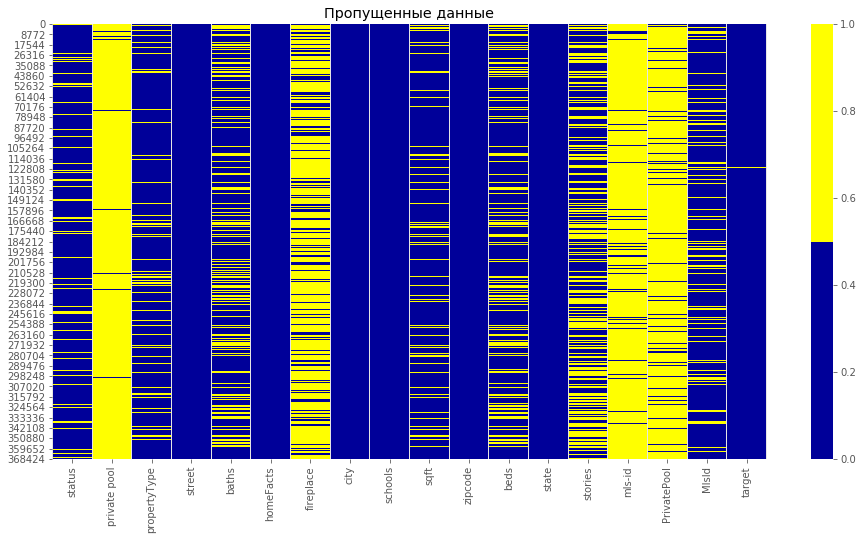

In [269]:
# Карта пропущенных значений
plt.style.use('ggplot')
plt.title('Пропущенные данные')
matplotlib.rcParams['figure.figsize'] = (20,10)

pd.options.mode.chained_assignment = None

cols = df.columns
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [271]:
# Процентный список пропущенных данных
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 3)))

status - 10.583%
private pool - 98.892%
propertyType - 9.208%
street - 0.001%
baths - 28.193%
homeFacts - 0.0%
fireplace - 72.662%
city - 0.009%
schools - 0.0%
sqft - 10.758%
zipcode - 0.0%
beds - 24.201%
state - 0.0%
stories - 39.958%
mls-id - 93.387%
PrivatePool - 89.313%
MlsId - 17.731%
target - 0.658%


In [ ]:
# Гистограмма пропущенных данных показывает количество строк с пропущенными данными
# сначала создаем индикатор для признаков с пропущенными данными
data_for_hist = data.copy()
for col in data_for_hist.columns:
    missing = data_for_hist[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        data_for_hist['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in data_for_hist.columns if 'ismissing' in col]
data_for_hist['num_missing'] = data_for_hist[ismissing_cols].sum(axis=1)

data_for_hist['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [69]:
# функции для обработки признаков

def privatePool(row):# все что не yes заменяем no
    if type(row['private pool']) is str:
        return row['private pool']
    elif type(row['PrivatePool']) is str:
        return row['PrivatePool']
    else:
        return 'no'
    
def mlsId(row):# обьединяем две колонки
    if type(row['mls-id']) is str:
        return row['mls-id']
    elif type(row['MlsId']) is str:
        return row['MlsId']
    else:
        return 'no mls'

def mlsIdNo(cell): # приводим к общему виду
    if cell.find('no')!=-1:
        return 'no mls'
    else:
        return cell

def factfeatures(row):# парсим homeFacts
    homeFacts = literal_eval(row['homeFacts'])
    fact_list = homeFacts['atAGlanceFacts']   
    for fact in fact_list:
        row[fact['factLabel']] = fact['factValue']   
    return row

def home(cell):#немного приводим к общему виду значения колонки propertyType
    if cell.find('single family')!=-1:
        return 'single family'
    elif cell.find('multi family')!=-1:
        return 'multi family'
    else:
        return cell

def bath_count(cell):# извлекаем числовые значения из колонки, nan заполняем -1
    if type(cell) is str:
        cell = cell.replace(',', '.')
        lst_bath = cell.split(' ')
        cnt = 0
        for item in lst_bath:
            digit_lst = re.findall(r'\d*\.\d+|\d+', item)
            for item2 in digit_lst:
                cnt = cnt + int(round(float(item2)))
        return int(cnt)
    else:
        return -1
    
def fireplace(cell):# 0 - no, nan - no data, yes
    if type(cell) is str:
        if (cell.find('0')!=-1) | (cell.find('not applicable')!=-1):
            return 'no'
        elif cell.find('no data')!=-1:
            return cell
        else:
            return 'yes'

# обрабатывает ячейки с числовыми значениями sqft, target, Price/sqft
def digit(cell):
    cell = cell.replace(',', '')
    result = re.search(r'\d+', cell)
    if result is not None:
        digit = result.group(0)
        if int(digit)>0:
            return int(digit)
        else:
            return -999
    else:
        return -999
    
# считает sqft по target и Price/sqft и заполняет недостающие
def sqft(row):
    if not row['sqft']>0:
        if (row['target']>0) & (row['Price/sqft']>0):
            sqft = int(round(row['target']/row['Price/sqft']))
            return sqft
        else:
            return row['sqft']
    else:
        return row['sqft']
    
# считает target по sqft и Price/sqft и заполняет недостающие
def target(row):
    if not row['target']>0:
        if (row['sqft']>0) & (row['Price/sqft']>0):
            target = int(round(row['sqft']*row['Price/sqft']/1000)*1000)
            return target
        else:
            return row['target']
    else:
        return row['target']

# считает Price/sqft по sqft и target и заполняет недостающие
def price_sqft(row):
    if not row['Price/sqft']>0:
        if (row['sqft']>0) & (row['target']>0):
            priceSqft = int(round(row['target']/row['sqft']))
            return priceSqft
        else:
            return row['Price/sqft']
    else:
        return row['Price/sqft']    
    
# заполним пропуски значениями из соседней колонки, если нет, то 0    
def year_built(row):
    if (row['Year built']!='') and (row['Year built']!='no data'):
        return row['Year built']  
    elif (row['Remodeled year']!='') and (row['Remodeled year']!='no data'):
        return row['Remodeled year']
    else:
        return '0'
    
def rem_year(row):
    if (row['Remodeled year']!='') and (row['Remodeled year']!='no data'):
        return row['Remodeled year']
    elif row['year_built']>0:
        return row['year_built']
    else:
        return 0
    
# считаем общее количество школ в районе, средний рейтинг, среднее растояние, количество школ по градациям
def schools(row):
    schoolsFacts = literal_eval(row['schools'])[0]
    ratings = schoolsFacts['rating']
    distances = schoolsFacts['data']['Distance']
    grades = schoolsFacts['data']['Grades']
    names = schoolsFacts['name']
    
    row['school_count'] = len(names)
    
    if len(names)>0:
        rat_full = 0
        dist_full = 0
        for rating in ratings:
            rat_full = rat_full + int(rating)
        row['school_rating_mean'] = round(rat_full/len(ratings), 1)
        
        for distance in distances:
            dist_full = dist_full + float(distance)
        row['school_distance_mean'] = round(dist_full/len(distances), 1)
        
        preschool = 0
        kindergarten = 0
        elementary = 0
        middle = 0
        high = 0
        private = 0
        for grade in grades:
            grade = str(grade)
            if grade.find('PK')!=-1:
                preschool = preschool + 1
            if (grade.find('K')!=-1) and (grade.find('PK')==-1):
                kindergarten = kindergarten + 1
            if (grade.find('-4')!=-1) or (grade.find('-5')!=-1) or (grade.find('-6')!=-1):
                elementary = elementary + 1
            if (grade.find('-7')!=-1) or (grade.find('-8')!=-1) or (grade.find('-9')!=-1):
                middle = middle + 1
            if (grade.find('-11')!=-1) or (grade.find('-12')!=-1):
                high = high + 1
                
        row['preschool'] = preschool
        row['kindergarten'] = kindergarten   
        row['elementary_school'] = elementary
        row['middle_school'] = middle
        row['high_school'] = high
        
        for name in names:
            if name.find('Private')!=-1:
                private = private + 1
        row['private_school'] = private
        
    else:
        row['school_rating_mean'] = 0
        row['school_distance_mean'] = 0
        row['preschool'] = 0
        row['kindergarten'] = 0 
        row['elementary_school'] = 0
        row['middle_school'] = 0
        row['high_school'] = 0
        row['private_school'] = 0
    
    return row

def beds(row):# получаем данные о площади lotsize
    if type(row['beds']) is str:
        if (row['beds'].find('acres')!=-1) or (row['beds'].find('sqft')!=-1):
            row['lotsize'] = row['beds']
            row['beds'] = 'no data'
    elif not row['beds']>0:
        row['beds'] = 'no data'
    return row

def beds2(cell):# извлекаем числовые значения
    if type(cell) is str:
        cell = cell.replace(',', '')
        result = re.search(r'\d+', cell)
        if result is not None:
            digit = result.group(0)
            return int(digit)
        else:
            return -1
    else:
        return -1
    
def lotsize(cell):# приводим к одним единицам площадь, nan - 0
    if type(cell) is str:
        cell = cell.replace('Sq. Ft.', 'sqft')
        cell = cell.replace('Acres', 'acres')
        cell = cell.replace(',', '')
        if cell.find('acres')!=-1:
            acres = float(cell.split(' ')[0]) # 1 acre = 43560 sqft
            sqft = int(round(acres*43560))
        else:
            result = re.search(r'\d+', cell)
            if result is not None:
                digit = result.group(0)
                sqft = int(digit)
            else:
                sqft = 0
        return sqft  
    else:
        return 0
    
def stories(row):# в колонке propertyType присутствуют данные stories - извлекаем
    if type(row['stories']) is float:
        if (row['propertyType'].find('one story')!=-1) or (row['propertyType'].find('1 story')!=-1):
            row['stories'] = 1
        if (row['propertyType'].find('two story')!=-1) or (row['propertyType'].find('2 story')!=-1):
            row['stories'] = 2
    return row

def stories2(cell):# извлекаем числовые значения
    if type(cell) is str:
        cell = cell.lower()
        if cell.find('one')!=-1:
            cell = 1
        elif cell.find('two')!=-1:
            cell = 2
        else:
            result = re.search(r'\d+', cell)
            if result is not None:
                digit = result.group(0)
                cell = int(digit)
            else:
                cell = 0
        return cell
    
def heating(cell):# приводим к общему виду некоторые значения
    if cell.find('forced')!=-1:
        cell = 'forced'
    if cell.find('central')!=-1:
        cell = 'central'
    if cell.find('electric')!=-1:
        cell = 'electric'
    if cell.find('gas')!=-1:
        cell = 'gas'
    if cell.find('window unit')!=-1:
        cell = 'wall/window unit'
    return cell

def cooling(cell):
    if cell.find('ceiling fan')!=-1:
        cell = 'ceiling fan'
    if cell.find('central')!=-1:
        cell = 'central'
    if cell.find('electric')!=-1:
        cell = 'electric'
    if cell.find('window unit')!=-1:
        cell = 'wall/window unit'
    return cell

def parking(cell):# разделяем все значения на yes, none, no data
    if cell=='no data':
        return cell
    elif cell=='none':
        return cell
    else:
        return 'yes'
    


In [4]:
# в некоторых моментах работает по 2 часа, 
# работает на florida и houston
# на всем датасете так и не удалось завершить до конца из-за непредвиденных ошибок
def preproc_data(df_input):
    tqdm.pandas(tqdm_notebook)
    data = df_input.copy()
    # Объединяем private pool и PrivatePool
    data['private_pool'] = data.apply(lambda x: privatePool(x), axis=1)
    data.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)
    data['private_pool'] = data['private_pool'].apply(lambda x: x.lower())
    # Объединяем mls-id, MlsId
    data['mls_Id'] = data.apply(lambda x: mlsId(x), axis=1)
    data.drop(['mls-id', 'MlsId'], axis=1, inplace=True)
    data['mls_Id'] = data['mls_Id'].apply(lambda x: x.lower())
    data['mls_Id'] = data['mls_Id'].apply(lambda x: mlsIdNo(x))
    # homeFacts
    print('homeFacts')
    data = data.progress_apply(lambda row: factfeatures(row), axis=1)
    data.drop('homeFacts', axis=1, inplace=True)
    # status
    data['status'] = data['status'].fillna('no data')
    data['status'] = data['status'].apply(lambda x: x.lower())
    data['status'] = data['status'].apply(lambda x: x.replace(',', ''))
    data['status'] = data['status'].apply(lambda x: x.replace('new construction', 'new'))
    data['status'] = data['status'].apply(lambda x: x.replace('a active', 'active'))
    data['status'] = data['status'].apply(lambda x: x.replace(' / auction', 'auction'))
    data['status'] = data['status'].apply(lambda x: x.replace('pre-foreclosureauction', 'pre-foreclosure auction'))
    data['status'] = data['status'].apply(lambda x: x.replace('under contract show', 'under contract'))
    data['status'] = data['status'].apply(lambda x: x.replace('under contract   showing', 'under contract'))
    data['status'] = data['status'].apply(lambda x: x.replace('active - auction', 'auction - active'))
    # city
    data['city'] = data['city'].fillna('no data')
    data['city'] = data['city'].apply(lambda x: x.lower())
    # propertyType
    data['propertyType'] = data['propertyType'].fillna('no data')
    data['propertyType'] = data['propertyType'].apply(lambda x: x.lower())
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('-', ' '))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace(' home', ''))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace(' / ', '/'))
    data['propertyType'] = data['propertyType'].apply(lambda x: home(x))
    # baths
    print('baths')
    data['baths_count'] = data['baths'].progress_apply(lambda x: bath_count(x))
    # fireplace
    data['fireplace'] = data['fireplace'].fillna('no data')
    data['fireplace'] = data['fireplace'].apply(lambda x: x.lower())
    data['fireplace_yes_no'] = data['fireplace'].apply(lambda x: fireplace(x))
    data.drop('fireplace', axis=1, inplace=True)
    # zipcode
    index = data[data['zipcode']=='--'].index
    data = data.drop(index, axis=0)
    data['zipcode'] = data['zipcode'].apply(lambda x: x.split('-')[0])
    data['zipcode'] = data['zipcode'].astype('int32')
    # sqft
    print('sqft')
    data['sqft'] = data['sqft'].fillna('no data')
    data['sqft'] = data['sqft'].astype('str')
    data['sqft'] = data['sqft'].apply(lambda x: digit(x))
    # Price/sqft
    print('Price/sqft')
    data['Price/sqft'] = data['Price/sqft'].fillna('no data')
    data['Price/sqft'] = data['Price/sqft'].astype('str')
    data['Price/sqft'] = data['Price/sqft'].apply(lambda x: digit(x))
    # target
    print('target')
    data['target'] = data['target'].fillna('no data')
    data['target'] = data['target'].astype('str')
    data['target'] = data['target'].apply(lambda x: digit(x))
    # Price/sqft sqft target
    data['Price/sqft'] = data.apply(lambda x: price_sqft(x), axis=1)
    data['sqft'] = data.apply(lambda x: sqft(x), axis=1)
    data['target'] = data.apply(lambda x: target(x), axis=1)
    # year_built, remodeled_year
    data['Year built'] = data['Year built'].fillna('no data')
    data['Remodeled year'] = data['Remodeled year'].fillna('no data')
    data['Year built'] = data['Year built'].apply(lambda x: x.lower())
    data['Remodeled year'] = data['Remodeled year'].apply(lambda x: x.lower())
    data['year_built'] = data.apply(lambda x: year_built(x), axis=1)
    data['year_built'] = data['year_built'].astype('int32')
    data['remodeled_year'] = data.apply(lambda x: rem_year(x), axis=1)
    data['remodeled_year'] = data['remodeled_year'].astype('int32')
    data.drop(['Year built', 'Remodeled year'], axis=1, inplace=True)
    # schools
    data['schools'] = data['schools'].apply(lambda x: x.replace('/10', ''))
    data['schools'] = data['schools'].apply(lambda x: x.replace(' mi', ''))
    data['schools'] = data['schools'].apply(lambda x: x.replace('mi', ''))
    data['schools'] = data['schools'].apply(lambda x: x.replace('NR', '0'))
    data['schools'] = data['schools'].apply(lambda x: x.replace('None', '0'))
    data['schools'] = data['schools'].apply(lambda x: x.replace('NA', '0'))
    data['schools'] = data['schools'].apply(lambda x: x.replace('Preschool', 'PK'))
    data['schools'] = data['schools'].apply(lambda x: x.replace(' to ', '-'))
    data['schools'] = data['schools'].apply(lambda x: x.replace('–', '-'))
    data['schools'] = data['schools'].apply(lambda x: x.replace('N/A', '1-8')) # пусть будет начальная и средняя школы
    print('schools')
    data = data.progress_apply(lambda row: schools(row), axis=1)
    data.drop('schools', axis=1, inplace=True)
    # beds
    print('beds')
    data = data.progress_apply(lambda row: beds(row), axis=1)
    data['beds'] = data['beds'].apply(lambda x: beds2(x))
    # lotsize
    print('lotsize')
    data['lotsize'] = data['lotsize'].progress_apply(lambda x: lotsize(x))
    # stories некоторые данные есть в propertyType
    print('stories')
    data = data.progress_apply(lambda row: stories(row), axis=1)
    print('stories')
    data['stories'] = data['stories'].progress_apply(lambda cell: stories2(cell))
    data['stories'] = data['stories'].fillna(0)
    # Heating
    data['Heating'] = data['Heating'].fillna('no data')
    data['Heating'] = data['Heating'].apply(lambda x: x.lower())
    data['Heating'] = data['Heating'].apply(lambda x: x.replace(',', ''))
    data['Heating'] = data['Heating'].apply(lambda x: heating(x))
    data['Heating'] = data['Heating'].apply(lambda x: x.replace('no heating', 'none'))
    data['Heating'] = data['Heating'].apply(lambda x: x.replace('has has', 'has'))
    # Cooling
    data['Cooling'] = data['Cooling'].fillna('no data')
    data['Cooling'] = data['Cooling'].apply(lambda x: x.lower())
    data['Cooling'] = data['Cooling'].apply(lambda x: x.replace(',', ''))
    data['Cooling'] = data['Cooling'].apply(lambda x: cooling(x))
    data['Cooling'] = data['Cooling'].apply(lambda x: x.replace('cenrtal ac', 'central'))
    # Parking
    data['Parking'] = data['Parking'].fillna('no data')
    data['Parking'] = data['Parking'].apply(lambda x: x.lower())
    data['Parking'] = data['Parking'].apply(lambda x: parking(x))
    # propertyType после обработки stories
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('1 story', 'no data'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 story', 'no data'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 stories', 'no data'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('one story', 'no data'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('two story', 'no data'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('co op', 'coop'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('cooperative', 'coop'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace(', no data', ''))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('no data, ', ''))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('florida', 'no data'))
    data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('other style', 'other'))
    # избавляемся от пустых значений в целевой переменной
    data = data[~data['Price/sqft'].isna()]
    # избавляемся от дубликатов
    key = ['city', 'sqft', 'zipcode', 'target', 'mls_Id', 'year_built']
    data.drop_duplicates(subset=key, inplace=True)
    return data

In [7]:
#preproc_df = preproc_data(df)

# dataset houston

In [76]:
houston = dataset[dataset['city']=='houston']
houston.shape

(24442, 18)

In [77]:
preproc_houston = preproc_data(houston)

D:\Anaconda\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


homeFacts



baths



target



schools



beds



lotsize



stories


In [84]:
preproc_houston.shape

(14595, 31)

In [83]:
preproc_houston.to_csv('D:\\SF\\Final\\houston.csv', index=False)

In [141]:
houston = pd.read_csv('D:\\SF\\Final\\houston.csv')
houston.shape

(14595, 31)

# Добавляем координаты почтовых отделений и центра городов. Считаем расстояние и азимут

In [4]:
# добавляет координаты почтовых отделений
def add_zip_coordinates(df_input, zipcode):
    df_output = df_input.copy()
    df_output = df_output.merge(zipcode[['postal_code', 'code1', 'latitude', 'longitude']], 
                                            how='inner',
                                            left_on='zipcode',
                                            right_on='postal_code')
    df_output.drop(['postal_code', 'code1'], axis=1, inplace=True)
    df_output.rename(columns={'latitude': 'zip_latitude', 'longitude': 'zip_longitude'}, inplace=True)
    return df_output

In [5]:
# добавляет координаты центра городов
def add_city_coordinates(df_input, US_cities):
    df_output = df_input.copy()
    df_output['state'] = df_output['state'].apply(lambda x: x.lower())
    US_cities['City'] = US_cities['City'].apply(lambda x: x.lower())
    US_cities['Region'] = US_cities['Region'].apply(lambda x: x.lower())
    df_output = df_output.merge(US_cities[['City', 'Region', 'Latitude', 'Longitude']], 
                                            how='inner',
                                            left_on=['city', 'state'],
                                            right_on=['City', 'Region'])
    df_output.rename(columns={'Latitude': 'city_latitude', 'Longitude': 'city_longitude'}, inplace=True)
    df_output.drop(['City', 'Region'], axis=1, inplace=True)
    return df_output

In [8]:
# получает координаты по адресу 
# используем  бесплатный сервис Nominatim
# работает очень долго из-за ограничений бесплатного сервиса
# иногда находит неверные координаты если не указан город
# в другом случае не находит координат если указан город
from geopy.geocoders import Nominatim

def get_geo_info(row, timeout=1):
    geo_locator = Nominatim()
    error = 'Location error'
    location = ''
    location2 = ''
    try:
        location = geo_locator.geocode(row['street'] + ' ' + row['city'], timeout=timeout)
    except Exception:
        row['adress_latitude'] = error
        row['adress_longitude'] = error
    
    if not location:
        try:
            location2 = geo_locator.geocode(row['street'], timeout=timeout)
        except Exception:
            row['adress_latitude'] = error
            row['adress_longitude'] = error
        if not location2:
            row['adress_latitude'] = error
            row['adress_longitude'] = error
        else:
            lat = location2.latitude
            long = location2.longitude
            row['adress_latitude'] = lat
            row['adress_longitude'] = long
    else:
        lat = location.latitude
        long = location.longitude
        row['adress_latitude'] = lat
        row['adress_longitude'] = long

    return row

In [156]:
# файл US.txt взят здесь http://download.geonames.org/export/zip/
zipcode = pd.read_csv('D:\\SF\\Final\\US.txt', sep='\t')

In [157]:
houston2 = add_zip_coordinates(houston, zipcode)
houston2.shape

(14595, 33)

In [158]:
# файл worldcitiespop.csv взят здесь https://www.kaggle.com/max-mind/world-cities-database
cities = pd.read_csv('D:\\SF\\Final\\worldcitiespop.csv')
US_cities = cities[(cities['Country']=='us') | (cities['Country']=='US')]

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
houston2 = add_city_coordinates(houston2, US_cities)
houston2.shape

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(14595, 35)

# Добавим колонки с количеством населения района

In [ ]:
# загрузил датасета с населением
# https://azure.microsoft.com/en-us/services/open-datasets/catalog/us-decennial-census-zip/#AzureNotebooks

# This is a package in preview.
#from azureml.opendatasets import UsPopulationZip
#population = UsPopulationZip()
#population_df = population.to_pandas_dataframe()

# получаем данные только по мужскому и женскому населению района
#zip_sex_pop = population_df.groupby(['zipCode', 'sex']).agg({'population':'sum'}).reset_index()
#table = pd.pivot_table(zip_sex_pop, values='population', index=['zipCode'], columns=['sex']).reset_index()
#table.to_csv('D:\\SF\\Final\\zip_sex_pop.csv', index=False)

In [185]:
zip_sex_pop = pd.read_csv('D:\\SF\\Final\\zip_sex_pop.csv')
zip_sex_pop.head()

,zipCode,Female,Male
0,601,37968,36312
1,602,84496,81584
2,603,112368,106388
3,606,13388,13072
4,610,59648,56416


In [190]:
houston3 = houston2.merge(zip_sex_pop, how='inner', left_on='zipcode', right_on='zipCode')
houston3.drop('zipCode', axis=1, inplace=True)
print(houston3.shape)

(14593, 39)


In [191]:
houston3.to_csv('D:\\SF\\Final\\houston_coord_pop.csv', index=False)

# Получаем координаты по адресу

In [ ]:
# работает 3 часа
tqdm.pandas(tqdm_notebook)
houston = dataset.progress_apply(lambda row: get_geo_info(row), axis=1)

In [ ]:
houston.to_csv('D:\\SF\\Final\\houston_coord_pop_adrcoord.csv', index=False)